I want to convey two things in this notebook.
## 1. Don't have to be hesitant about using Loop.
They say "avoid loops!'.
But I think It's not bad idea to use loops for this competition.
Because:
* We have to use small batch inference using Time-series API.
* Loops have very small overhead for each batch.
* Loops are more flexible.
* Even loops are not so slow. 3 features are extracted within 10 minits for 100M train data, as you can see blow.

## 2. Future information should not be used.
Time-series API doesn't allow us to use information from the future.
So we should not use it, especially user statistics from future make things very bad.

In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
import random
import os

## Setting
CV files are generated by [this notebook](https://www.kaggle.com/its7171/cv-strategy)

In [2]:
train_pickle = '../input/riiid-cross-validation-files/cv1_train.pickle'
valid_pickle = '../input/riiid-cross-validation-files/cv1_valid.pickle'
question_file = '../input/riiid-test-answer-prediction/questions.csv'
debug = False
validaten_flg = False

## Feature engineering

In [3]:
# funcs for user stats with loop
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def add_user_feats_without_update(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(df[['user_id']].values):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def update_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    for row in df[['user_id','answered_correctly','content_type_id']].values:
        if row[2] == 0:
            answered_correctly_sum_u_dict[row[0]] += row[1]
            count_u_dict[row[0]] += 1

In [4]:
# read data
feld_needed = ['row_id', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train = pd.read_pickle(train_pickle)[feld_needed]
valid = pd.read_pickle(valid_pickle)[feld_needed]
if debug:
    train = train[:1000000]
    valid = valid[:10000]
train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

# answered correctly average for each content
content_df = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c']
train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

# user stats features with loops
answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)
valid = add_user_feats(valid, answered_correctly_sum_u_dict, count_u_dict)

# fill with mean value for prior_question_elapsed_time
# note that `train.prior_question_elapsed_time.mean()` dose not work!
# please refer https://www.kaggle.com/its7171/can-we-trust-pandas-mean for detail.
prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# use only last 30M training data for limited memory on kaggle env.
#train = train[-30000000:]

# part
questions_df = pd.read_csv(question_file)
train = pd.merge(train, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid = pd.merge(valid, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

## Modeling

In [5]:
TARGET = 'answered_correctly'
FEATS = ['answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'answered_correctly_avg_c', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time']
dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

In [6]:
lgb_train = lgb.Dataset(train[FEATS], y_tr)
lgb_valid = lgb.Dataset(valid[FEATS], y_va)
del train, y_tr
_=gc.collect()

## Quote:
- The high parameters are quoted from below:
- [Riiid model LGBM](https://www.kaggle.com/ragnar123/riiid-model-lgbm)

In [7]:
# Random seed
SEED = 123

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(SEED)

[20]	training's auc: 0.750035	valid_1's auc: 0.755927
[40]	training's auc: 0.750964	valid_1's auc: 0.756858
[60]	training's auc: 0.751324	valid_1's auc: 0.757181
[80]	training's auc: 0.751558	valid_1's auc: 0.757393
[100]	training's auc: 0.751727	valid_1's auc: 0.757541
[120]	training's auc: 0.751826	valid_1's auc: 0.757614
[140]	training's auc: 0.751889	valid_1's auc: 0.757646
[160]	training's auc: 0.751934	valid_1's auc: 0.757678
[180]	training's auc: 0.751985	valid_1's auc: 0.757699
[200]	training's auc: 0.752027	valid_1's auc: 0.757719
auc: 0.7577185889460427


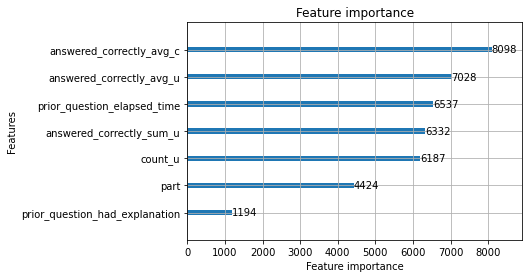

In [8]:
model = lgb.train(                   
                    {'objective': 'binary',
                     "boosting_type": "gbdt",
                     'seed': SEED,
                     'metric': 'auc',
                     'num_leaves': 200,
                     'feature_fraction': 0.75,
                     'bagging_freq': 10,
                     'bagging_fraction': 0.80
                    }, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=20,
                    num_boost_round=200,
                    # early_stopping_rounds=10
                )
print('auc:', roc_auc_score(y_va, model.predict(valid[FEATS])))
_ = lgb.plot_importance(model)

## Inference

In [9]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df['user_answer'].astype(str).values
        self.answered_correctly = df['answered_correctly'].astype(str).values
        df['prior_group_responses'] = "[]"
        df['prior_group_answers_correct'] = "[]"
        self.sample_df = df[df['content_type_id'] == 0][['row_id']]
        self.sample_df['answered_correctly'] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self
    
    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df= self.df[pre_start:self.current].copy()
        sample_df = self.sample_df[pre_start:self.current].copy()
        df.loc[pre_start,'prior_group_responses'] = '[' + ",".join(self.pre_user_answer_list) + ']'
        df.loc[pre_start,'prior_group_answers_correct'] = '[' + ",".join(self.pre_answered_correctly_list) + ']'
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1
        pre_content_type_id = -1
        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_user_id in added_user and (crr_user_id != pre_added_user or (crr_task_container_id != pre_task_container_id and crr_content_type_id == 0 and pre_content_type_id == 0)):
                # known user(not prev user or (differnt task container and both question))
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if  crr_user_id == pre_added_user and (crr_task_container_id == pre_task_container_id or crr_content_type_id == 1):
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(self.answered_correctly[self.current])
                    self.current += 1
                    continue
                else:
                    return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            pre_content_type_id = crr_content_type_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

In [10]:
# You can debug your inference code to reduce "Submission Scoring Error" with `validaten_flg = True`.
# Please refer https://www.kaggle.com/its7171/time-series-api-iter-test-emulator about Time-series API (iter_test) Emulator.

if validaten_flg:
    target_df = pd.read_pickle(valid_pickle)
    if debug:
        target_df = target_df[:10000]
    iter_test = Iter_Valid(target_df,max_user=1000)
    predicted = []
    def set_predict(df):
        predicted.append(df)
    # reset answered_correctly_sum_u_dict and count_u_dict
    answered_correctly_sum_u_dict = defaultdict(int)
    count_u_dict = defaultdict(int)
    train = pd.read_pickle(train_pickle)[['user_id','answered_correctly','content_type_id']]
    if debug:
        train = train[:1000000]
    train = train[train.content_type_id == False].reset_index(drop=True)
    update_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)
    del train
else:
    import riiideducation
    env = riiideducation.make_env()
    iter_test = env.iter_test()
    set_predict = env.predict

In [11]:
previous_test_df = None
for (test_df, sample_prediction_df) in iter_test:
    if previous_test_df is not None:
        previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
        update_user_feats(previous_test_df, answered_correctly_sum_u_dict, count_u_dict)
    previous_test_df = test_df.copy()
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = add_user_feats_without_update(test_df, answered_correctly_sum_u_dict, count_u_dict)
    test_df = pd.merge(test_df, content_df, on='content_id',  how="left")
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
    test_df['prior_question_elapsed_time_mean'] = test_df.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
    test_df[TARGET] =  model.predict(test_df[FEATS])
    set_predict(test_df[['row_id', TARGET]])

In [12]:
if validaten_flg:
    y_true = target_df[target_df.content_type_id == 0].answered_correctly
    y_pred = pd.concat(predicted).answered_correctly
    print(roc_auc_score(y_true, y_pred))